In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
dataSet = loadmat('anomaly.mat')

In [3]:
X = dataSet['X']
x1 = dataSet['xtest1']
x2 = dataSet['xtest2']

In [4]:
Xtest = X[0]

In [5]:
def GaussianKernel(y,d):
    arg = -1/2*np.dot(y,y)
    const = (2*np.pi)**(-d/2)
    out = const*np.exp(arg)
    return out

In [6]:
def LOOCV(X,K,n):
    
    def f1(h,X,K,n):
        d = X[0].size
        toAdd = []
        for i in range(n):
            for j in range(n):
                if h!=0:
                    k = (np.sqrt(2)*h)**(-d)*K((X[i]-X[j])/(np.sqrt(2)*h),d)
                    toAdd.extend([k])
                else:
                    k = 0
                    toAdd.extend([k])
        added = np.sum(toAdd)
        term = 1/(n**2) * added
        return term
    
    
    def f2(h,X,K,n):
        d = X[0].size
        toAdd = []
        for i in range(n):
            js = [k for k in range(n) if k!=i]
            for j in js:
                if h!=0:
                    k = h**(-d)*K((X[i]-X[j])/(h),d)
                    toAdd.extend([k])
                else:
                    k = 0
                    toAdd.extend([k])
        added = np.sum(toAdd)
        term = 2/(n*(n-1)) * added
        return term
    
    def F(h):
        return f1(h,X,K,n) - f2(h,X,K,n)
    
    res = minimize_scalar(F)
    return res

In [7]:
test = LOOCV(Xtest,GaussianKernel,Xtest.shape[0])

In [8]:
test

     fun: -0.42972028611251256
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 24
     nit: 20
 success: True
       x: 0.08055754589217583

In [9]:
#our h value is thus test.x = 0.08.

In [10]:
hHat = test.x
hHat

0.08055754589217583

In [11]:
def KDE(x,X,K,h,n):
    d = X[0].size
    toAdd=[]
    for i in range(n):
        k = h**(-d)*K((X[i]-x)/(h),d)
        toAdd.extend([k])
    added = np.sum(toAdd)
    term = 1/n * added
    return term

In [12]:
Xspace = np.linspace(-2,4,500)

In [13]:
Yspace = [KDE(xi,Xtest,GaussianKernel,hHat,Xtest.size) for xi in Xspace]

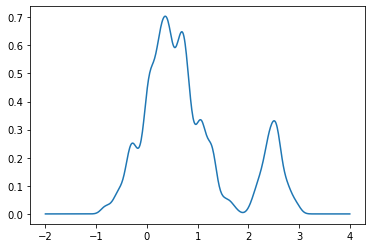

In [14]:
plt.plot(Xspace,Yspace)

In [15]:
#This looks like a gaussian mixture density.

In [16]:
#Now let's get the first outlier score 1.

In [17]:
x1Point = x1[0][0]
x2Point = x2[0][0]
print(x1Point)
print(x2Point)

2.85
-1.5


In [18]:
def OS1(x,X,K,h,n):
    d = X[0].size
    numer = KDE(x,X,K,h,n)
    toAdd = []
    for j in range(n):
        toAddMini = []
        Is = [k for k in range(n) if k!=j]
        for i in Is:
            k = h**(-d)*K((x-X[i])/(h),d)
            toAddMini.extend([k])
        addedMini = np.sum(toAddMini)
        termMini = 1/(n-1) * addedMini
        toAdd.extend([termMini])
    added = np.sum(toAdd)
    denom = 1/n * added
    term = numer/denom
    return denom

In [19]:
print(OS1(x1Point,Xtest,GaussianKernel,hHat,Xtest.size))
print(OS1(x2Point,Xtest,GaussianKernel,hHat,Xtest.size))

0.07682991783568469
6.968724621388073e-17


In [20]:
#Now let's get the outlier scores using the second formula.

In [21]:
def OS2(x,X,K,h,n,k):
    #First let's get pk(x). this will be duplicate code, but this is difference since x is not in the training data.
    distances = [distance.euclidean(x,X[i]) for i in range(n)]
    distDict = {distances[i]: X[i] for i in range(n)}
    distances.sort()
    firstK = [distances[i] for i in range(k)]
    Nx = [distDict[i] for i in firstK]
    #rhoK = Nx[-1]
    rhoK = firstK[-1]
    
    #Now let's get pk(xi). Much of this is duplicate code, but we can now handle xi being in the training data.
    def pk(xi):
        distances = [distance.euclidean(xi,X[i]) for i in range(n)]
        #distDict = {distances[i]: X[i] for i in range(n)}
        distances.sort()
        #firstK = [distances[i] for i in range(k+1)] #we add 1 because the first distance is 0.
        #firstKm1 = firstK[1:len(firstK):]
        #Nx = [distDict[i] for i in firstKm1]
        pk = distances[k+1] #Nx[-1]
        return pk
    
    toAdd = [pk(pt) for pt in Nx] #[pk(pt) for pt in Nx]
    added = np.sum(toAdd)
    denom = 1/k * added
    term = rhoK/denom
    #print(rhoK)
    #print(denom)
    return term

In [22]:
print(OS2(x1Point,Xtest,GaussianKernel,hHat,Xtest.size,100))
print(OS2(x1Point,Xtest,GaussianKernel,hHat,Xtest.size,150))
print(OS2(x1Point,Xtest,GaussianKernel,hHat,Xtest.size,200))

1.402373014864521
1.7068412176827588
1.946628746494562


In [23]:
print(OS2(x2Point,Xtest,GaussianKernel,hHat,Xtest.size,100))
print(OS2(x2Point,Xtest,GaussianKernel,hHat,Xtest.size,150))
print(OS2(x2Point,Xtest,GaussianKernel,hHat,Xtest.size,200))

4.365527024372908
4.268168807031261
3.966913023970989
